In [1]:
# 1. Imports and file paths
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# File paths (adjust if needed)
CSV_PATH = "indian_health_policies.csv"
TRAIN_PATH = "indian_health_policies_train.csv"
TEST_PATH = "indian_health_policies_test.csv"
MODEL_PATH = "health_policy_vectorizer.pkl"
MATRIX_PATH = "health_policy_tfidf_matrix.pkl"

print('Paths set. CSV_PATH =', CSV_PATH)

Paths set. CSV_PATH = indian_health_policies.csv


In [2]:
# 2. Load the data (auto-detects CSV file even if name slightly differs)
import os
import pandas as pd
import glob

# Try to find the CSV automatically
csv_files = glob.glob("indian_health_policies*.csv")

if len(csv_files) == 0:
    raise FileNotFoundError("❌ No file found matching 'indian_health_policies*.csv'. Please upload it.")
else:
    CSV_PATH = csv_files[0]
    print(f"✅ Found dataset file: {CSV_PATH}")

# Load the data
df = pd.read_csv(CSV_PATH)
print(f"📄 Loaded {CSV_PATH} with {len(df)} rows and {len(df.columns)} columns.")

# Check first few rows
display(df.head())

# Check if train/test files already exist
TRAIN_PATH = "indian_health_policies_train.csv"
TEST_PATH = "indian_health_policies_test.csv"

train_exists = os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH)
if train_exists:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
    print(f"✅ Found existing train/test files: {len(train_df)} train, {len(test_df)} test.")

✅ Found dataset file: indian_health_policies .csv
📄 Loaded indian_health_policies .csv with 7 rows and 10 columns.


,policy_id,title,sector,region,year,target_group,status,budget (₹ crore),summary,full_text
0,H001,National Health Mission (NHM),Health,All India,2013,"Rural population, women, children",Implemented,37000,Umbrella program integrating NRHM & NUHM for b...,The NHM aims to strengthen healthcare delivery...
1,H002,Ayushman Bharat (PM-JAY),Health,All India,2018,Poor & vulnerable families,Implemented,6400,Provides health insurance coverage up to ₹5 la...,Ayushman Bharat is the world's largest governm...
2,H003,Polio Eradication Initiative,Health,All India,1995,Children under 5,Completed,500,Nationwide vaccination drive to eradicate polio,India launched the Pulse Polio Immunization ca...
3,H004,Janani Suraksha Yojana (JSY),Health,All India,2005,Pregnant women,Ongoing,2000,Promotes institutional deliveries to reduce ma...,JSY provides financial incentives to pregnant ...
4,H005,National Mental Health Programme,Health,All India,1982,General population,Under Review,500,"Focus on mental health awareness, care facilit...",The NMHP aims to integrate mental health into ...


✅ Found existing train/test files: 5 train, 2 test.


In [3]:
# 3. Preprocess: build a text_for_nlp field using title + summary + full_text
def preprocess(df):
    df = df.copy()
    # Ensure required columns exist
    required_cols = ['title', 'summary', 'full_text']
    for c in required_cols:
        if c not in df.columns:
            df[c] = ''
    df['text_for_nlp'] = (df['title'].astype(str) + '. ' + df['summary'].astype(str) + '. ' + df['full_text'].astype(str)).str.strip().str.lower()
    return df

df = preprocess(df)
print('Preprocessing done. Example text:')
print(df['text_for_nlp'].iloc[0][:400])

Preprocessing done. Example text:
national health mission (nhm). umbrella program integrating nrhm & nuhm for better healthcare access. the nhm aims to strengthen healthcare delivery by improving rural and urban health services, maternal & child health, and communicable disease control.


In [4]:
# 4. Create train/test if not present and save them
if not (os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH)):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    train_df.to_csv(TRAIN_PATH, index=False)
    test_df.to_csv(TEST_PATH, index=False)
    print(f"Created and saved train/test: {len(train_df)} train, {len(test_df)} test.")
else:
    # train_df/test_df already loaded earlier
    pass

TF-IDF trained. Vocabulary size = 240
TF-IDF matrix shape: (7, 240), Sparsity: 16.85%
Top 20 words/phrases by TF-IDF importance:
health: 1.57
healthcare: 0.95
to: 0.93
the: 0.74
provides: 0.61
and: 0.60
coverage: 0.59
polio: 0.58
mission: 0.48
by: 0.40
mental: 0.40
mental health: 0.40
national: 0.38
aims to: 0.37
aims: 0.37
maternal: 0.37
in: 0.33
free: 0.30
india: 0.30
immunization: 0.29


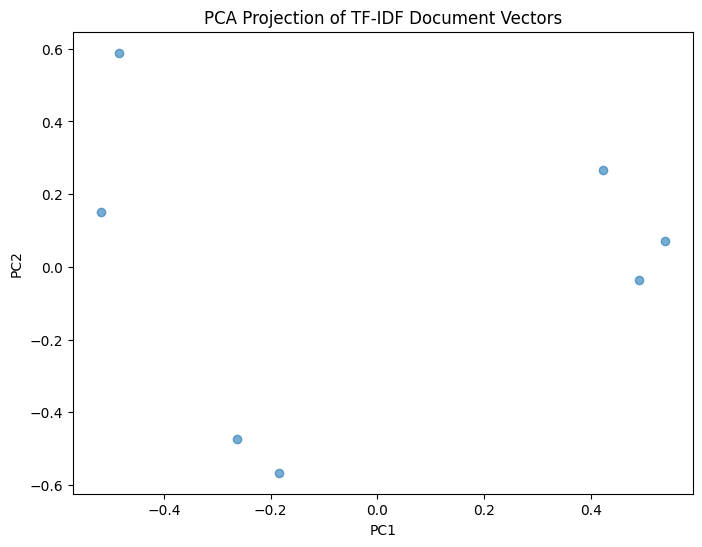

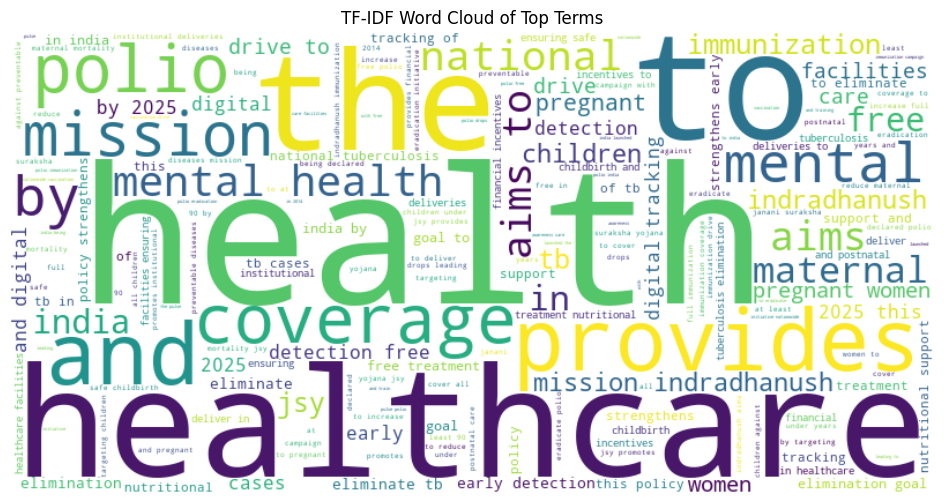

In [5]:
# 5. Train TF-IDF vectorizer on train data
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
vectorizer.fit(train_df['text_for_nlp'].fillna(''))

# Transform full dataset for downstream tasks
tfidf_matrix = vectorizer.transform(df['text_for_nlp'].fillna(''))

print('TF-IDF trained. Vocabulary size =', len(vectorizer.get_feature_names_out()))
# --------------------------
# TF-IDF Visualization
# --------------------------
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from wordcloud import WordCloud

# 1. Sparsity
sparsity = 100.0 * (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}, Sparsity: {sparsity:.2f}%")

# 2. Top 20 words
feature_names = np.array(vectorizer.get_feature_names_out())
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[::-1][:20]
print("Top 20 words/phrases by TF-IDF importance:")
for word, score in zip(feature_names[top_indices], tfidf_sum[top_indices]):
    print(f"{word}: {score:.2f}")

# 3. PCA Projection
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.6)
plt.title("PCA Projection of TF-IDF Document Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 4. Word Cloud
top_words_dict = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud of Top Terms")
plt.show()


In [6]:
# 6. Save the vectorizer and the matrix
joblib.dump(vectorizer, MODEL_PATH)
joblib.dump({'matrix': tfidf_matrix, 'df': df}, MATRIX_PATH)

print(f"Saved vectorizer to {MODEL_PATH} and matrix+df to {MATRIX_PATH}.")

Saved vectorizer to health_policy_vectorizer.pkl and matrix+df to health_policy_tfidf_matrix.pkl.


In [7]:
# 7. Quick example: nearest-similarity lookup (cosine) for a query
from sklearn.metrics.pairwise import cosine_similarity
query = "health insurance for vulnerable families"
q_vec = vectorizer.transform([query.lower()])
sims = cosine_similarity(q_vec, tfidf_matrix).flatten()
top_idx = sims.argsort()[::-1][:5]
results = df.iloc[top_idx][['policy_id','title','year','summary']].copy()
results['score'] = sims[top_idx]
results.reset_index(drop=True, inplace=True)
print('Top matches for query:') 
print(results.to_string(index=False))

Top matches for query:
policy_id                             title  year                                                               summary    score
     H001     National Health Mission (NHM)  2013 Umbrella program integrating NRHM & NUHM for better healthcare access 0.700237
     H002          Ayushman Bharat (PM-JAY)  2018           Provides health insurance coverage up to ₹5 lakh per family 0.469899
     H005  National Mental Health Programme  1982       Focus on mental health awareness, care facilities, and training 0.399356
     H006 National Tuberculosis Elimination  2017                                 Goal to eliminate TB in India by 2025 0.000000
     H007              Mission Indradhanush  2014 Immunization drive to cover all children against preventable diseases 0.000000


In [8]:
import os
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# --- Config ---
TARGET_CSV_NAME = "indian_health_policies.csv"
MODEL_PATH = "health_policy_vectorizer.pkl"
MATRIX_PATH = "health_policy_tfidf_matrix.pkl"

# -----------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------
def find_csv_file(search_dir="."):
    target_root = os.path.splitext(TARGET_CSV_NAME)[0].strip().lower()
    for fname in os.listdir(search_dir):
        if fname.lower().endswith(".csv"):
            root = os.path.splitext(fname)[0].strip().lower()
            if root == target_root or target_root in root or root in target_root:
                return os.path.join(search_dir, fname)
    return None

def load_dataframe(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    for col in ["title", "summary", "full_text"]:
        if col not in df.columns:
            raise KeyError(f"Missing expected column: {col} (available: {list(df.columns)})")
        df[col] = df[col].fillna("")
    return df

def preprocess(df):
    df = df.copy()
    df["text_for_nlp"] = (
        df["title"].astype(str) + ". " +
        df["summary"].astype(str) + ". " +
        df["full_text"].astype(str)
    ).str.lower()
    return df

def train_and_save(df, model_path=MODEL_PATH, matrix_path=MATRIX_PATH):
    train_df, _ = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
    vectorizer.fit(train_df["text_for_nlp"])
    tfidf_matrix = vectorizer.transform(df["text_for_nlp"])
    joblib.dump(vectorizer, model_path)
    joblib.dump({"matrix": tfidf_matrix, "df": df}, matrix_path)

def query_policy(question, top_k=3, model_path=MODEL_PATH, matrix_path=MATRIX_PATH):
    data = joblib.load(matrix_path)
    tfidf_matrix = data["matrix"]
    df = data["df"]
    vectorizer = joblib.load(model_path)
    query_vec = vectorizer.transform([question.lower()])
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = similarities.argsort()[::-1][:top_k]
    results = df.iloc[top_indices][
        ["title", "summary", "full_text", "region", "year", "status"]
    ].copy()
    results["score"] = similarities[top_indices]
    return results.reset_index(drop=True)

def display_results(question, results):
    print(f"\n🔎 Query: {question}\n")
    for _, row in results.iterrows():
        title = row.get("title", "Unknown Policy")
        summary = (row.get("summary", "") or "").strip()
        summary_short = summary[:250] + "..." if len(summary) > 250 else summary
        region = row.get("region", "N/A")
        year = row.get("year", "N/A")
        status = row.get("status", "N/A")
        score = row.get("score", 0)
        print(f"📌 {title} | Score={score:.3f}")
        print(f"Region: {region} | Year: {year} | Status: {status}")
        print(f"Summary: {summary_short}\n")

# -----------------------------------------------------------
# Main Execution
# -----------------------------------------------------------
if __name__ == "__main__":
    csv_path = find_csv_file(".")
    if csv_path is None and os.path.exists("Infosys_1"):
        csv_path = find_csv_file("Infosys_1")
    if csv_path is None:
        available = [f for f in os.listdir(".") if f.lower().endswith(".csv")]
        raise FileNotFoundError(
            f"Couldn't find dataset similar to '{TARGET_CSV_NAME}'. CSV files found: {available}"
        )

    df = load_dataframe(csv_path)
    df = preprocess(df)
    train_and_save(df)

    # Example query (you can modify this line)
    question = "Maternal health programs in rural areas"
    results = query_policy(question, top_k=3)
    display_results(question, results)



🔎 Query: Maternal health programs in rural areas

📌 National Health Mission (NHM) | Score=0.613
Region: All India | Year: 2013 | Status: Implemented
Summary: Umbrella program integrating NRHM & NUHM for better healthcare access

📌 Ayushman Bharat (PM-JAY) | Score=0.309
Region: All India | Year: 2018 | Status: Implemented
Summary: Provides health insurance coverage up to ₹5 lakh per family

📌 National Mental Health Programme | Score=0.304
Region: All India | Year: 1982 | Status: Under Review
Summary: Focus on mental health awareness, care facilities, and training

